In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
# rcParams['figure.figsize'] = 5, 4
# rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

# select device: change to 'cpu' if there's no GPU device
device = 'gpu'

if device == 'gpu':
    torch.cuda.set_device(0)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

if device == 'cpu':
    torch.set_default_tensor_type(torch.DoubleTensor)


In [2]:
class ScaleAndShift(nn.Module):
    def __init__(self, input_features, K=1):
        super(ScaleAndShift, self).__init__()
        self.input_features = input_features
        self.K = K

        
        self.rawscale = nn.Parameter(torch.Tensor(input_features,K))
        self.shift = nn.Parameter(torch.Tensor(input_features,K))

        self.rawscale.data.uniform_(-1, 1)
        self.shift.data.uniform_(-1, 1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        
        batch_no = input.shape[0]
        p = self.input_features
        
        K = self.K
        
        self.logscale = - torch.nn.functional.softplus(self.rawscale)
        self.scale = torch.exp(self.logscale)
        
        x_rep = input.reshape([batch_no,1,p]).repeat(1,K,1)
        w_rep = self.scale.T.reshape([1,K,p]).repeat(batch_no,1,1)
        b_rep = self.shift.T.reshape([1,K,p]).repeat(batch_no,1,1)

        return x_rep*w_rep+b_rep

    def print_param(self):

        return 'scale={}, shift={}'.format(
            self.scale, self.shift
        )
    

In [3]:
class KCat(nn.Module):
    def __init__(self, input_features, K=1):
        super(KCat, self).__init__()
        self.input_features = input_features
        self.K = K
        
        self.w = nn.Parameter(torch.Tensor(input_features,K))
        self.b0 = nn.Parameter(torch.Tensor(K))

        self.w.data.uniform_(-1, 1)
        self.b0.data.uniform_(-1, 1)

        
    def forward(self, input,dim=1):
        
        b = self.b0 - torch.logsumexp(self.b0,0,keepdim=True)
        w = torch.tanh(self.w)
        xw_b = input@w+ b
        return xw_b - torch.logsumexp(xw_b,dim=dim,keepdim=True)

In [4]:
batch_no = 1000
p = 2
K = 100

In [5]:
scale_shift = ScaleAndShift(p,K)
kcat = KCat(p,K)

In [6]:
def H_torch(x,y):
    sin=torch.sin
    cos=torch.cos
    cosh=torch.cosh
    barrier = 1E10
    threshold = 1.1
    
    return - (x * sin(20*y)+ y*sin(20*x))**2* cosh(sin(10*x)*x) - (x*cos(10*y)- y*sin(10*x))**2 * cosh(cos(20*y)*y) +  (x.abs()-threshold)*(x.abs()>threshold)*barrier +  (y.abs()-threshold)*(y.abs()>threshold)*barrier 

In [7]:
def H_np(x,y):
    sin=np.sin
    cos=np.cos
    cosh=np.cosh
    barrier = 1E10

    return - (x * sin(20*y)+ y*sin(20*x))**2* cosh(sin(10*x)*x) - (x*cos(10*y)- y*sin(10*x))**2 * cosh(cos(20*y)*y)+ (np.abs(x)>1.1)*barrier + (np.abs(y)>1.1)*barrier 

In [8]:
def getNp(x):
    return x.detach().cpu().numpy()

In [9]:
class Loglik(nn.Module):
    def __init__(self):
        super(Loglik, self).__init__()
        
    def f(self, theta):
        x = theta[:,:,0]
        y = theta[:,:,1]

        loglik = - H_torch(x,y) * temperature
        return  loglik

compLoglik = Loglik()

In [10]:
para_list=list()
para_list +=  list(scale_shift.parameters())
para_list +=  list(kcat.parameters())

In [11]:
import copy

best_loss = np.inf

Optimize to learn the random transport, as a mixture of K maps

In [12]:

def dirichlet_prior(logb):
    alpha= 0.5
    return (alpha/K-1) * log_b.sum()

In [13]:
optimizer = torch.optim.Adam([p for p in para_list if p.requires_grad==True], lr=1e-2)

In [14]:
temperature = 1.2

for t in range(3000):
    
    r = 1
    beta = torch.rand([batch_no,p])* r - r/2.

    theta = scale_shift(beta)
    
    
    mix_weight = torch.diagonal(kcat(theta,dim=2),0,1,2) #kcat(beta)

    logjacobian = scale_shift.logscale.sum(0)

    target_log_density = compLoglik.f(theta) + logjacobian

    weighted_target = target_log_density + mix_weight

    total = torch.logsumexp(weighted_target,dim=1)
    
    #regularize b:    
    log_b = kcat.b0 - torch.logsumexp(kcat.b0,0, keepdim=True)
    w = kcat.w
    

    loss =  - total.mean()
    total_loss =  loss + dirichlet_prior(log_b)   
    
    if t%100==0:
        print(t, - total.mean())
          

    if total_loss.item()< best_loss:
        param_bak = copy.deepcopy( [scale_shift.state_dict(), kcat.state_dict()])
        best_loss = total_loss.item()

        
    if np.isnan(loss.item()):
        scale_shift = ScaleAndShift(p,K)
        kcat = KCat(p,K)
        scale_shift.load_state_dict(param_bak[0])
        kcat.load_state_dict(param_bak[1])
        kcat.eval()
        scale_shift.eval()
#         optimizer.zero_grad()
        pass
          
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    total_loss.backward(retain_graph=True)

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 tensor(-0.4306, grad_fn=<NegBackward>)
100 tensor(-2.7161, grad_fn=<NegBackward>)
200 tensor(-3.3074, grad_fn=<NegBackward>)
300 tensor(-3.5046, grad_fn=<NegBackward>)
400 tensor(-3.5974, grad_fn=<NegBackward>)
500 tensor(-3.7385, grad_fn=<NegBackward>)
600 tensor(-3.8376, grad_fn=<NegBackward>)
700 tensor(-3.9036, grad_fn=<NegBackward>)
800 tensor(-4.0196, grad_fn=<NegBackward>)
900 tensor(-4.0944, grad_fn=<NegBackward>)
1000 tensor(-4.1219, grad_fn=<NegBackward>)
1100 tensor(-4.1179, grad_fn=<NegBackward>)
1200 tensor(-4.1010, grad_fn=<NegBackward>)
1300 tensor(-4.1614, grad_fn=<NegBackward>)
1400 tensor(-4.1130, grad_fn=<NegBackward>)
1500 tensor(-4.1399, grad_fn=<NegBackward>)
1600 tensor(-4.1548, grad_fn=<NegBackward>)
1700 tensor(-4.1453, grad_fn=<NegBackward>)
1800 tensor(-4.2105, grad_fn=<NegBackward>)
1900 tensor(-4.1897, grad_fn=<NegBackward>)
2000 tensor(-4.1885, grad_fn=<NegBackward>)
2100 tensor(-4.2195, grad_fn=<NegBackward>)
2200 tensor(-4.1819, grad_fn=<NegBackward>)


In [15]:
g= getNp( - total[:1000])

In [16]:
post_sample_beta=list()
post_sample_theta=list()
post_sample_choice =list()
post_sample_map_choice =list()

for i in range(50):
    theta = scale_shift(beta)
    mix_weight = torch.diagonal(kcat(theta,dim=2),0,1,2) #kcat(beta)
    logjacobian = scale_shift.logscale.sum(0)

    target_log_density = compLoglik.f(theta) + logjacobian

    weighted_target = target_log_density + mix_weight
    theta_np = getNp(theta)

    weight_np =getNp(weighted_target)

    pick = np.argmax(weight_np+ np.random.gumbel(size= [batch_no,K]),axis=1)
    map_pick = np.argmax(weight_np,axis=1)

    post_sample_beta.append(getNp(beta))
    post_sample_theta.append(np.array([theta_np[i,pick[i],:] for i in range(batch_no)]))
    post_sample_choice.append(pick)
    post_sample_map_choice.append(map_pick)

beta_sample = np.vstack(post_sample_beta)
theta_sample = np.vstack(post_sample_theta)
post_sample_choice = np.hstack(post_sample_choice)
post_sample_map_choice = np.hstack(post_sample_map_choice)

In [17]:
rcParams['figure.dpi'] = 300

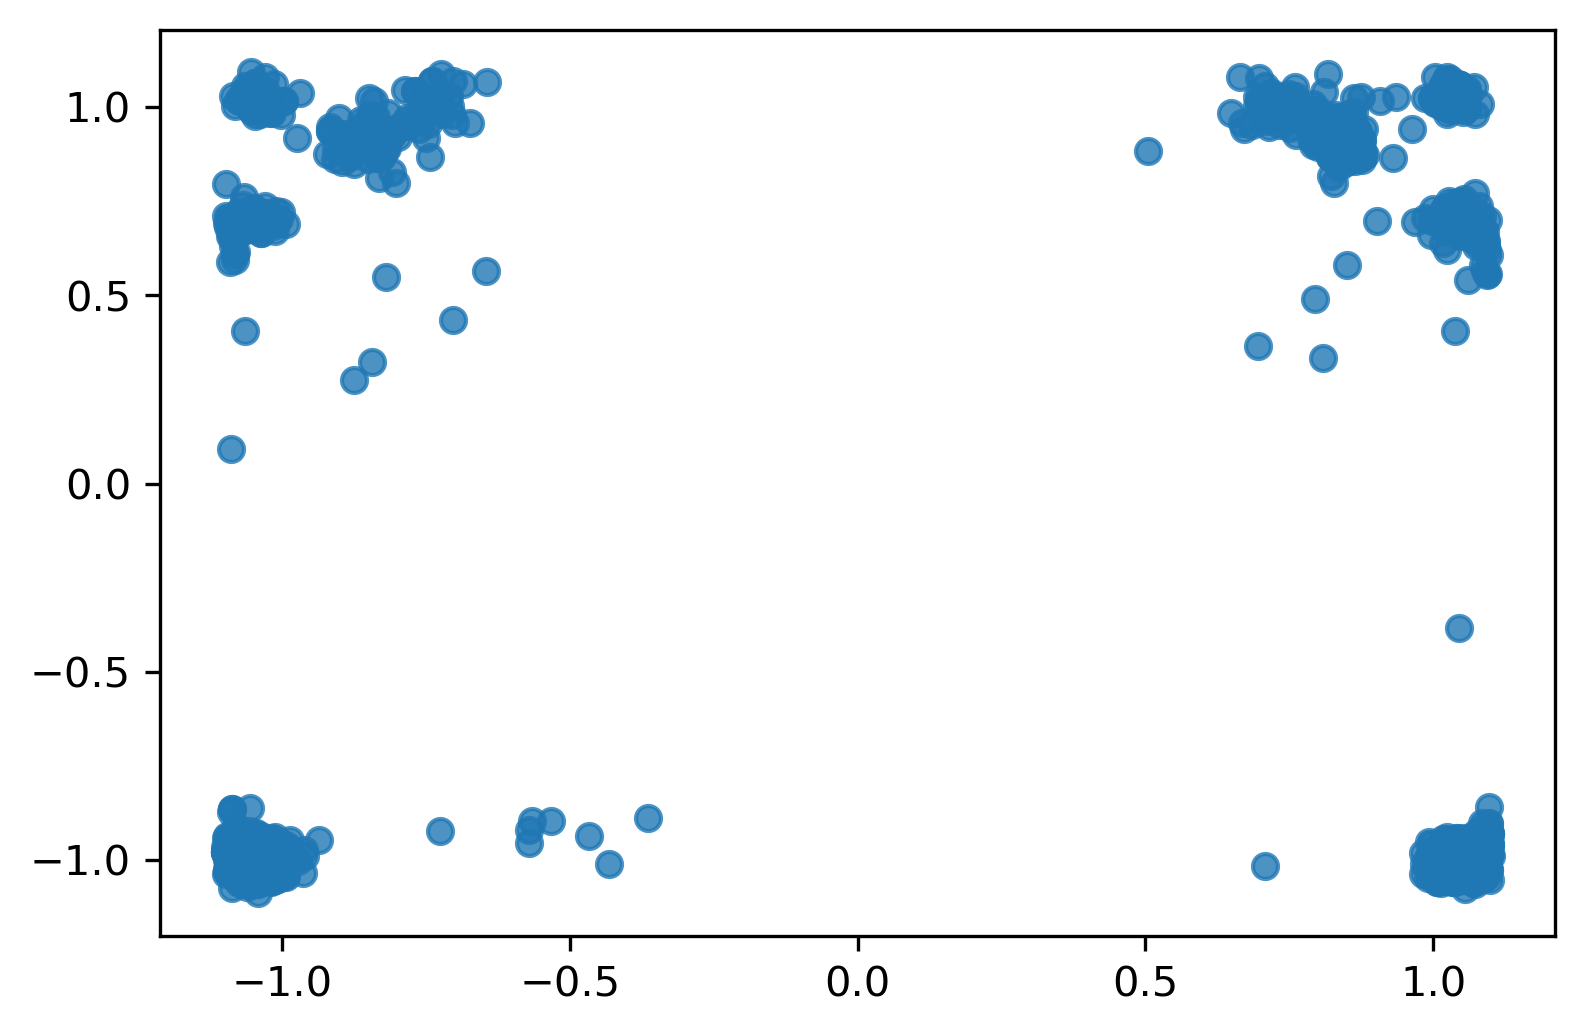

In [18]:
# col = np.argmax(((theta_sample@kcat_w)+kcat_b) + np.random.gumbel(0,1,[10000,100]),1)
# col = np.argmax(((theta_sample@kcat_w)+kcat_b) ,1)
col = post_sample_choice
_, col1 = np.unique(col, return_inverse=True)


plot_n = 3000
plt.figure(figsize=[6, 4])
plt.scatter(theta_sample[:plot_n,0],theta_sample[:plot_n,1], alpha=.8,cmap='jet')
# plt.ylim(-2,2)
# plt.xlim(-2,2)